# MOVEIT!    LAUNCH IT!
#OSCII CODED

## Setup

必要なライブラリをインポートして、初期化を行います。

Import the required libraries and initialize them:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion
import sys
import time

from utils_notebooks import *
import cv2
import os




In [3]:
import moveit_commander
import moveit_msgs.msg
head = moveit_commander.MoveGroupCommander('head')

In [4]:


## THIS PATH MUST BE SET BY USER () 


#_path_model = "/home/oscar/Codes/ycb_ws/src/robot_object_views/robotobject/models"   Tenshi Version

_path_model = "/home/oscar/Codes/catkin_mio_ws/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 
#_path_model = "/home/roboworks/Codes/catkin_mio/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 


objs=os.listdir(_path_model)
objs.sort()
print (objs)

['person_standing', 'training_wall', 'trofast', 'wrc_bin_black', 'wrc_bin_green', 'wrc_bookshelf', 'wrc_container_a', 'wrc_container_b', 'wrc_frame', 'wrc_ground_plane', 'wrc_long_table', 'wrc_stair_like_drawer', 'wrc_tall_table', 'wrc_tray', 'ycb_002_master_chef_can', 'ycb_003_cracker_box', 'ycb_004_sugar_box', 'ycb_005_tomato_soup_can', 'ycb_006_mustard_bottle', 'ycb_007_tuna_fish_can', 'ycb_008_pudding_box', 'ycb_009_gelatin_box', 'ycb_010_potted_meat_can', 'ycb_011_banana', 'ycb_012_strawberry', 'ycb_013_apple', 'ycb_014_lemon', 'ycb_015_peach', 'ycb_016_pear', 'ycb_017_orange', 'ycb_018_plum', 'ycb_019_pitcher_base', 'ycb_021_bleach_cleanser', 'ycb_022_windex_bottle', 'ycb_024_bowl', 'ycb_025_mug', 'ycb_026_sponge', 'ycb_027_skillet', 'ycb_028_skillet_lid', 'ycb_029_plate', 'ycb_030_fork', 'ycb_031_spoon', 'ycb_032_knife', 'ycb_033_spatula', 'ycb_035_power_drill', 'ycb_036_wood_block', 'ycb_037_scissors', 'ycb_038_padlock', 'ycb_040_large_marker', 'ycb_042_adjustable_wrench', 'ycb

In [10]:
#AGAIN THIS PATH MUST BE SET ( IT IS LOCATED IN NOTEBOOK UTILS FILE utils_notebooks.py)

rvizを起動します．ロボットモデル、カメラ映像、ポイントクラウドが表示されています。

In [11]:
#Initialize  Ros Node
rospy.init_node("recognition")


In [12]:
#create a RGBD() object to read xtion
rgbd = RGBD()

In [13]:
#Create a tf listener to read tf tree ( shockingly)
listener = tf.TransformListener()
rospy.sleep(.5)

Launch RViz. The robot model, camera image, and point cloud are displayed:

In [14]:
def gazebo_2_world(x,y):

    x_world= x+2.1
    y_world= -(y-1.2)
    return (x_world,y_world)

def world_2_gazebo(y_world , x_world):

    x= ( x_world - 2.1)
    y= (-y_world + 1.2) 
    return (x , y)

In [15]:
#Get pose of the xtion w.r.t map frame 
#( odom , or hsrb base vfootprint might be other 
#useful reference frames)


trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
#trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_link', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

trans, euler

([0.012813885679227503, 0.021025034340916186, 0.9918587404688984],
 (-4.896527627884014e-12, -0.0019197229155860636, -0.012854398687004352))

In [17]:
#moveit
#MOVE IT MUST BE RUNNING. DECLARE A HEAD POSE
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-30)
#WATCH OUT FOR JOINTS LIMITS (exorcist joke)

In [18]:
#plan and execute target pose
head.set_joint_value_target(head_val)
head.go()

True

In [19]:
#Get pose of the xtion w.r.t map frame 

trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
#trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_link', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

trans, euler


([0.156935498318622, 0.018806818123987257, 1.0032083523900257],
 (-4.896528258571794e-12, 0.5238269673144247, -0.014919435181702112))

In [20]:
model_name = objs[-1]
print model_name

ycb_077_rubiks_cube


In [21]:
#USE TRANSFORM TREE TF TO SPAWN A STATIC MODEL
# D_to_cam  METERS AWAY FROM XTION ON THE dIRECTION OF IT FOCAL POINT


#x_gaz,y_gaz=world_2_gazebo(1.15,0.02)
deg=0
D_to_cam= 0.6
x_gaz,y_gaz=world_2_gazebo(+trans[0]+ D_to_cam * np.cos(euler[2]), +  trans[1]+ D_to_cam * np.sin(euler[2]))
z_gaz= trans[2]- D_to_cam*np.sin(euler[1])
spawn_object(model_name, model_name, x_gaz,  y_gaz,  z_gaz, 1.5* np.pi , 0,euler[2])
#spawn_object(model_name+'1', model_name, x_gaz,  y_gaz, z_gaz ,-.5*np.pi , .5*np.pi, euler[2])     #spawn_object(model_name+'1', model_name, x_gaz,  y_gaz, z_gaz,0.5*np.pi , 0 ,euler[2])
#spawn_object(model_name+'2', model_name, x_gaz,  y_gaz,  z_gaz, np.pi,0 ,euler[2])
#spawn_object(model_name+'3', model_name, x_gaz,  y_gaz,  z_gaz, 1.5*np.pi ,0,euler[2]+np.pi)

[INFO] [1617632017.938665, 291.316000]: Spawn: ycb_077_rubiks_cube
[INFO] [1617632017.943529, 291.316000]: Spawn: [ 0.00527477  0.00527477  0.70708711 -0.70708711]
[INFO] [1617632017.952205, 291.317000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1617632017.970039, 291.318000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1617632018.262141, 291.334000]: Spawn status: SpawnModel: Successfully spawned entity


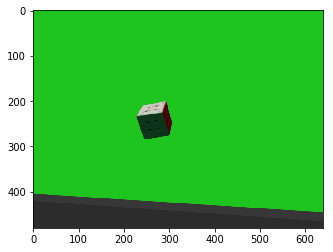

In [70]:
#GET AND SHOW IMAGE
cv2_img = rgbd.get_image()
plt.imshow(cv2_img)
#delete_object(model_name)


In [71]:
#delete_object(model_name)
#delete_object(model_name+str(1))
#delete_object(model_name+str(2))
#delete_object(model_name+str(3))


segmented image not centered, adjusting....


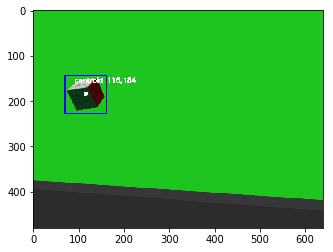

In [93]:
close_enough= False
goal_cX=cv2_img.shape[1]*.5
goal_cY=cv2_img.shape[0]*.5
cv2_img = rgbd.get_image()
img=cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
#img= np.copy(cv2_img)
low= np.array([0,100,0])
high= np.array([100,200,100])
mask = cv2.inRange(cv2_img, low, high)
mask_buena= cv2.morphologyEx(mask,cv2.MORPH_ERODE,np.ones((9,9),np.uint8))
masked_image = np.copy(img)
masked_image[mask_buena != 0] = [0, 0, 0]

#
### FIND OBJECTS ( CONTOURS FINDING IN MASKED IMAGE)

ret,thresh = cv2.threshold(mask_buena,127,255,0)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
i=find_2nd_biggest_contour_ix(contours)
boundRect = cv2.boundingRect(contours[find_2nd_biggest_contour_ix(contours)])#contours_poly[i])
img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,0,0), 2)
##DRAW BOUNDIG RECT AROUND SECOND BIIGGEST CONTOUR ( WHY SECOND PLEASE THINK ABOUT IT, and EXPERIMENT)
#img_roi=img[y:y+h,x:x+w,:]
#img_resized=cv2.resize(img_roi,(img_width,img_height))
ret,thresh = cv2.threshold(mask_buena,127,255,0)
c=contours[find_2nd_biggest_contour_ix(contours)]
# calculate moments for each contour
M = cv2.moments(c)
# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
cv2.putText(img, "centroid "+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
cv2_img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#cv2.imshow('press key to quit',img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
plt.imshow(cv2_img)
head_val=head.get_current_joint_values()
if (cX < .45* goal_cX):
    head_val[0]+= np.deg2rad(10)
elif (cY < .45*goal_cY):
    head_val[1]=np.deg2rad(5)
elif (cX >= .55*goal_cX):
    head_val[0]+= np.deg2rad(-10)
elif (cY >= .55*goal_cY):
    head_val[1]=np.deg2rad(-5)
else:
    close_enough=True

if not close_enough:
    print('segmented image not centered, adjusting....')
    head.set_joint_value_target(head_val)
    head.go()
else:
    print ('close enough')

    

In [25]:
import datetime
ct = datetime.datetime.now()
print("current time:-", ct)

('current time:-', datetime.datetime(2021, 3, 29, 16, 44, 56, 664223))


レゴブロックが頭部カメラの画角に入るように頭を少し下げます。rviz上の頭部カメラの映像が変化することを確認しましょう。

Lower the head slightly so that the Lego block is within the viewing angle of the head camera. Check that the image in the head camera in RViz changes accordingly:

In [56]:
#Capture a frame each degdree while changing static object pose
#I dont love this way of spawining and  deleting, 
#CONTROL VIA ROS TOPIC POSE !
samples_rev=100
start = time.time()
model_name=objs[81]
D_to_cam=.75
for j in range (3):
    deg=0
    
    for i in range (samples_rev):
        trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
        euler=tf.transformations.euler_from_quaternion(rot)
        deg+= np.deg2rad(i*2*np.pi/samples_rev)
        print(i,deg)
        x_gaz,y_gaz=world_2_gazebo(       trans[0]+ D_to_cam * np.cos(euler[2]),   trans[1]+ D_to_cam * np.sin(euler[2])    )
        z_gaz= trans[2]- D_to_cam*np.sin(euler[1])

        #spawn_object("lego2", model_name, x_gaz,  y_gaz, trans[2], 0.8)
        #spawn_object(model_name, model_name, x_gaz,  y_gaz, trans[2]- D_to_cam* np.sin(euler[1]) , 2*np.pi*np.random.rand() ,2*np.pi*np.random.rand(),2*np.pi*np.random.rand())
        spawn_object(model_name, model_name, x_gaz,  y_gaz,  z_gaz, +.4+.1*j*np.pi, 0 ,deg)
        
        cap_cnt= i
        rospy.sleep(.1)
        cv2_img = rgbd.get_image()

        cap_name = "/home/roboworks/Desktop/images3/"+model_name+"_"+str(j*30)+"deg""_{}.png".format(cap_cnt)   ##SAVE YOUR IMAGES WHEREVER YOU WAnt
        #cap_name = "imagesfromlistener/image_from_listener_{}.png".format(cap_cnt)
        im_rgb = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(cap_name, im_rgb)
        delete_object(model_name)
end = time.time()


    

(0, 0.0)
[INFO] [1616955924.579480, 890.209000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616955924.584049, 890.210000]: Spawn: [0.         0.         0.19866933 0.98006658]
[INFO] [1616955924.588646, 890.210000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616955924.595237, 890.211000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616955924.738228, 890.229000]: Spawn status: SpawnModel: Successfully spawned entity
(1, 0.001096622711232151)
[INFO] [1616955926.800200, 890.507000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616955926.802503, 890.508000]: Spawn: [-1.08932645e-04  5.37381607e-04  1.98669301e-01  9.80066431e-01]
[INFO] [1616955926.805358, 890.508000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616955926.810502, 890.509000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616955927.022678, 890.531000]: Spawn status: SpawnModel: Successfully spawned entity
(2, 0.0032898681336964533)
[INFO] [1616955928.882219, 890.806000]: Spawn: ycb_072-c_toy_airplane
[INFO]

(19, 0.20835831513410868)
[INFO] [1616955963.222310, 895.629000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616955963.224792, 895.629000]: Spawn: [-0.02065979  0.10191792  0.1975922   0.97475291]
[INFO] [1616955963.226339, 895.629000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616955963.237875, 895.631000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616955963.304908, 895.635000]: Spawn status: SpawnModel: Successfully spawned entity
(20, 0.2302907693587517)
[INFO] [1616955965.361273, 895.938000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616955965.364412, 895.938000]: Spawn: [-0.02282534  0.11260094  0.19735376  0.97357667]
[INFO] [1616955965.366151, 895.938000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616955965.389551, 895.944000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616955965.603688, 895.967000]: Spawn status: SpawnModel: Successfully spawned entity
(21, 0.2533198462946269)
[INFO] [1616955967.385222, 896.233000]: Spawn: ycb_072-c_toy_airplane
[INF

[INFO] [1616955999.946094, 900.706000]: Spawn status: SpawnModel: Successfully spawned entity
(38, 0.8125974290230237)
[INFO] [1616956001.788885, 900.979000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956001.791029, 900.979000]: Spawn: [-0.07851652  0.38733415  0.18249564  0.90027926]
[INFO] [1616956001.792447, 900.979000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956001.796837, 900.980000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956002.047861, 901.009000]: Spawn status: SpawnModel: Successfully spawned entity
(39, 0.8553657147610776)
[INFO] [1616956003.861069, 901.272000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956003.867878, 901.272000]: Spawn: [-0.08240078  0.40649583  0.18077504  0.89179125]
[INFO] [1616956003.869496, 901.272000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956003.878822, 901.274000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956003.928713, 901.276000]: Spawn status: SpawnModel: Successfully spawned entity
(40, 0

(57, 1.8127173416667453)
[INFO] [1616956041.494269, 906.180000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956041.496520, 906.180000]: Spawn: [-0.15640514  0.7715708   0.12250279  0.60432524]
[INFO] [1616956041.498513, 906.181000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956041.517833, 906.183000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956041.731506, 906.209000]: Spawn status: SpawnModel: Successfully spawned entity
(58, 1.87632145891821)
[INFO] [1616956043.560339, 906.459000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956043.562965, 906.460000]: Spawn: [-0.16022124  0.79039621  0.11746768  0.57948626]
[INFO] [1616956043.564486, 906.460000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956043.567931, 906.460000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956043.625252, 906.463000]: Spawn status: SpawnModel: Successfully spawned entity
(59, 1.9410221988809069)
[INFO] [1616956045.631949, 906.742000]: Spawn: ycb_072-c_toy_airplane
[INFO] 

[INFO] [1616956077.642224, 911.357000]: Spawn status: SpawnModel: Successfully spawned entity
(76, 3.2087180530652737)
[INFO] [1616956079.433641, 911.617000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956079.437196, 911.618000]: Spawn: [-0.19855745  0.97951463 -0.00666663 -0.03288751]
[INFO] [1616956079.438432, 911.618000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956079.443136, 911.618000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956079.511851, 911.623000]: Spawn status: SpawnModel: Successfully spawned entity
(77, 3.2931580018301494)
[INFO] [1616956081.312493, 911.888000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956081.315005, 911.888000]: Spawn: [-0.19809912  0.97725366 -0.01504129 -0.074201  ]
[INFO] [1616956081.316766, 911.889000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956081.318952, 911.889000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956081.420959, 911.897000]: Spawn status: SpawnModel: Successfully spawned entity
(78, 3

(95, 5.000599563218609)
[INFO] [1616956117.235807, 916.992000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956117.238785, 916.992000]: Spawn: [-0.11885034  0.58630714 -0.1591983  -0.78534988]
[INFO] [1616956117.240595, 916.992000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956117.243873, 916.993000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956117.308851, 916.998000]: Spawn status: SpawnModel: Successfully spawned entity
(96, 5.105875343496895)
[INFO] [1616956119.089408, 917.243000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956119.092859, 917.244000]: Spawn: [-0.11030973  0.544175   -0.16523095 -0.81510985]
[INFO] [1616956119.095888, 917.244000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956119.106766, 917.246000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956119.172915, 917.251000]: Spawn status: SpawnModel: Successfully spawned entity
(97, 5.212247746486414)
[INFO] [1616956120.676011, 917.474000]: Spawn: ycb_072-c_toy_airplane
[INFO] [

[INFO] [1616956153.118164, 922.118000]: Spawn status: SpawnModel: Successfully spawned entity
(14, 0.11514538467937585)
[INFO] [1616956154.960882, 922.392000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956154.963641, 922.393000]: Spawn: [-0.02011282  0.05391131  0.34896044  0.93536926]
[INFO] [1616956154.965320, 922.393000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956154.970364, 922.393000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956155.194425, 922.421000]: Spawn status: SpawnModel: Successfully spawned entity
(15, 0.1315947253478581)
[INFO] [1616956156.994651, 922.680000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956156.997397, 922.680000]: Spawn: [-0.02298219  0.0616025   0.34878322  0.93489423]
[INFO] [1616956156.999107, 922.681000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956157.001632, 922.681000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956157.055665, 922.684000]: Spawn status: SpawnModel: Successfully spawned entity
(16, 

(32, 0.5790167915305756)
[INFO] [1616956190.389343, 927.396000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956190.391649, 927.396000]: Spawn: [-0.09978695  0.26747342  0.33499325  0.89793099]
[INFO] [1616956190.393235, 927.396000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956190.396674, 927.397000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956190.617950, 927.424000]: Spawn status: SpawnModel: Successfully spawned entity
(33, 0.6152053410012366)
[INFO] [1616956192.416547, 927.680000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956192.418503, 927.680000]: Spawn: [-0.10583174  0.28367616  0.33313294  0.89294452]
[INFO] [1616956192.419694, 927.680000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956192.423465, 927.681000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956192.499843, 927.687000]: Spawn status: SpawnModel: Successfully spawned entity
(34, 0.6524905131831297)
[INFO] [1616956194.305979, 927.933000]: Spawn: ycb_072-c_toy_airplane
[INFO

(51, 1.454121715093832)
[INFO] [1616956228.714405, 932.824000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956228.717513, 932.824000]: Spawn: [-0.23233077  0.62274985  0.26115192  0.70000337]
[INFO] [1616956228.719255, 932.825000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956228.745309, 932.829000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956228.989501, 932.857000]: Spawn status: SpawnModel: Successfully spawned entity
(52, 1.5111460960779037)
[INFO] [1616956230.794379, 933.107000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956230.797158, 933.107000]: Spawn: [-0.23968134  0.64245266  0.25442242  0.6819653 ]
[INFO] [1616956230.799354, 933.108000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956230.808609, 933.109000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956230.873951, 933.113000]: Spawn status: SpawnModel: Successfully spawned entity
(53, 1.5692670997732077)
[INFO] [1616956232.712491, 933.374000]: Spawn: ycb_072-c_toy_airplane
[INFO]

(70, 2.725107437411895)
[INFO] [1616956266.408118, 938.185000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956266.412359, 938.186000]: Spawn: [-0.34198803  0.91668011  0.07226409  0.19369992]
[INFO] [1616956266.413787, 938.186000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956266.417983, 938.186000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956266.496318, 938.194000]: Spawn status: SpawnModel: Successfully spawned entity
(71, 2.8029676499093776)
[INFO] [1616956268.310153, 938.462000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956268.312624, 938.463000]: Spawn: [-0.34454145  0.92352442  0.05889907  0.15787571]
[INFO] [1616956268.314176, 938.463000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956268.322338, 938.464000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956268.390603, 938.467000]: Spawn status: SpawnModel: Successfully spawned entity
(72, 2.8819244851180925)
[INFO] [1616956270.173838, 938.715000]: Spawn: ycb_072-c_toy_airplane
[INFO]

[INFO] [1616956301.524399, 943.198000]: Spawn status: SpawnModel: Successfully spawned entity
(89, 4.391973958484765)
[INFO] [1616956303.297792, 943.451000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956303.302873, 943.453000]: Spawn: [-0.28342471  0.75970434 -0.20456869 -0.54833512]
[INFO] [1616956303.304738, 943.453000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956303.308051, 943.454000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956303.398837, 943.461000]: Spawn status: SpawnModel: Successfully spawned entity
(90, 4.4906700024956585)
[INFO] [1616956305.179853, 943.714000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956305.183789, 943.714000]: Spawn: [-0.27298871  0.73173123 -0.21830043 -0.58514229]
[INFO] [1616956305.185601, 943.715000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956305.205699, 943.717000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956305.270956, 943.722000]: Spawn status: SpawnModel: Successfully spawned entity
(91, 4.

(7, 0.030705435914500225)
[INFO] [1616956339.863777, 948.648000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956339.866434, 948.649000]: Spawn: [-0.00755022  0.01336719  0.49174503  0.87060389]
[INFO] [1616956339.867673, 948.649000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956339.872529, 948.650000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956340.104586, 948.681000]: Spawn status: SpawnModel: Successfully spawned entity
(8, 0.039478417604357434)
[INFO] [1616956341.943376, 948.942000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956341.946563, 948.942000]: Spawn: [-0.00970717  0.01718594  0.49170718  0.87053688]
[INFO] [1616956341.947977, 948.943000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956341.955501, 948.943000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956342.198535, 948.977000]: Spawn status: SpawnModel: Successfully spawned entity
(9, 0.049348022005446794)
[INFO] [1616956344.215478, 949.252000]: Spawn: ycb_072-c_toy_airplane
[I

(26, 0.384914571642485)
[INFO] [1616956377.651882, 953.905000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956377.655319, 953.905000]: Spawn: [-0.09406784  0.16654124  0.48272292  0.85463082]
[INFO] [1616956377.659387, 953.905000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956377.672767, 953.909000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956377.751549, 953.913000]: Spawn status: SpawnModel: Successfully spawned entity
(27, 0.4145233848457531)
[INFO] [1616956379.541623, 954.163000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956379.544229, 954.163000]: Spawn: [-0.1012037   0.17917483  0.48127746  0.85207171]
[INFO] [1616956379.545956, 954.163000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956379.553736, 954.165000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956379.621001, 954.169000]: Spawn status: SpawnModel: Successfully spawned entity
(28, 0.4452288207602533)
[INFO] [1616956381.415153, 954.423000]: Spawn: ycb_072-c_toy_airplane
[INFO]

[INFO] [1616956413.595544, 958.948000]: Spawn status: SpawnModel: Successfully spawned entity
(45, 1.135004506125276)
[INFO] [1616956415.429856, 959.219000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956415.432920, 959.220000]: Spawn: [-0.26435764  0.4680287   0.41471101  0.73421996]
[INFO] [1616956415.434413, 959.220000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956415.439352, 959.221000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956415.661864, 959.249000]: Spawn status: SpawnModel: Successfully spawned entity
(46, 1.185449150841955)
[INFO] [1616956417.460294, 959.503000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956417.462250, 959.503000]: Spawn: [-0.27473242  0.48639661  0.4079121   0.72218291]
[INFO] [1616956417.464025, 959.503000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956417.480816, 959.505000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956417.561728, 959.509000]: Spawn status: SpawnModel: Successfully spawned entity
(47, 1.2

[INFO] [1616956452.035630, 964.337000]: Spawn status: SpawnModel: Successfully spawned entity
(64, 2.2809752393628737)
[INFO] [1616956453.858486, 964.595000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956453.861576, 964.595000]: Spawn: [-0.44696876  0.7913303   0.2051563   0.36321643]
[INFO] [1616956453.862907, 964.596000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956453.880187, 964.599000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956454.121548, 964.627000]: Spawn status: SpawnModel: Successfully spawned entity
(65, 2.3522557155929635)
[INFO] [1616956455.922069, 964.879000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956455.924058, 964.879000]: Spawn: [-0.45399519  0.80377015  0.18909931  0.33478854]
[INFO] [1616956455.925512, 964.879000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956455.928153, 964.879000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956455.997238, 964.883000]: Spawn status: SpawnModel: Successfully spawned entity
(66, 2

(83, 3.8228267713552784)
[INFO] [1616956492.859681, 969.974000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956492.862308, 969.974000]: Spawn: [-0.46354827  0.82068329 -0.16429602 -0.29087585]
[INFO] [1616956492.864236, 969.974000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956492.874379, 969.974000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956493.068755, 970.003000]: Spawn status: SpawnModel: Successfully spawned entity
(84, 3.914943079098779)
[INFO] [1616956494.938319, 970.268000]: Spawn: ycb_072-c_toy_airplane
[INFO] [1616956494.940810, 970.268000]: Spawn: [-0.45549219  0.8064205  -0.18546441 -0.32835317]
[INFO] [1616956494.943307, 970.269000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616956494.949909, 970.269000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616956495.134518, 970.292000]: Spawn status: SpawnModel: Successfully spawned entity
(85, 4.008156009553512)
[INFO] [1616956496.974281, 970.561000]: Spawn: ycb_072-c_toy_airplane
[INFO] 

In [57]:
print( 'time elapsed in trainSing video',(end - start)/60,'mins')


('time elapsed in trainSing video', 10.035553546746572, 'mins')


#TO MAKE MR EDD HAPPY MAKE A VIDEO OUT OF THIS FRAMES
#on terminal go to folder containing the images and run
# $ffmpeg -framerate 30  -pattern_type glob -i '*.png' -r 5 video.mp4
# It is advisable to name each video other than video.mp4

In [208]:
#USE TRANSFORM TREE TF TO SPAWN A STATIC MODEL
# D_to_cam  METERS AWAY FROM XTION ON THE dIRECTION OF IT FOCAL POINT


#x_gaz,y_gaz=world_2_gazebo(1.15,0.02)
deg=0
model_name= 'ycb_065-g_cups'   #for cups
D_to_cam= 0.35
x_gaz,y_gaz=world_2_gazebo(+trans[0]+ D_to_cam * np.cos(euler[2]), -.05+  trans[1]+ D_to_cam * np.sin(euler[2]))
z_gaz= -.03+trans[2]- D_to_cam*np.sin(euler[1])
spawn_object(model_name, model_name, x_gaz,  y_gaz,  z_gaz, 0 ,0 ,euler[2]+.6*np.pi)
spawn_object(model_name+'1', model_name, x_gaz,  y_gaz, z_gaz, 0.5*np.pi,0 ,euler[2]+.8*np.pi)
spawn_object(model_name+'2', model_name, x_gaz,  y_gaz,  z_gaz, np.pi,0 ,euler[2]+np.pi)
spawn_object(model_name+'3', model_name, x_gaz,  y_gaz,  z_gaz, 1.5*np.pi ,0,euler[2]+1.2*np.pi)

[INFO] [1616780636.851553, 2044.097000]: Spawn: ycb_065-g_cups
[INFO] [1616780636.854740, 2044.097000]: Spawn: [0.         0.25419119 0.         0.96715399]
[INFO] [1616780636.868240, 2044.102000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616780636.881347, 2044.103000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616780637.187791, 2044.146000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1616780637.190000, 2044.146000]: Spawn: ycb_065-g_cups
[INFO] [1616780637.192990, 2044.146000]: Spawn: [-0.38227409  0.38227409  0.59486681  0.59486681]
[INFO] [1616780637.194392, 2044.147000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1616780637.204108, 2044.148000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1616780637.442557, 2044.177000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1616780637.444452, 2044.177000]: Spawn: ycb_065-g_cups
[INFO] [1616780637.446289, 2044.177000]: Spawn: [-7.74123844e-01  4.74014144e-17  6.33034181e-01 

'ycb_065-g_cups'

'ycb'